In [33]:
# colors = {'1':'r', '2':'g', 'Iris-virginica':'b'}

# # fig, ax = plt.subplots()
# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d') 
# for i in range(len(X_train)):
#      ax.scatter(X_train[i][5] ,X_train[i][1], X_train[i][2],color=colors[Y_train[i]] , s=50, alpha=0.6, edgecolors='w')


In [34]:
# library 😚

import sklearn.datasets as datasets
import pandas as pd
from sklearn.tree import DecisionTreeClassifier

from sklearn.externals.six import StringIO  
# from IPython.display import Image  
from IPython.display import Image, display
from sklearn.tree import export_graphviz
import pydotplus

from scipy.io.arff import loadarff

import numpy as np
from sklearn import metrics

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import collections

In [35]:
# config 😚
path_to_datasets = '/home/farzad/Desktop/semiWithTree/originDataset/'
dataset_name = 'bupa'


dataset_path  = path_to_datasets + dataset_name
base_classifier = DecisionTreeClassifier
random_state = 0
min_samples_leaf=3

In [36]:
def divide_xy(test_data):
    # assert : class = last atr 😚
    x_test = test_data.values[:, 0:-1]
    y_test = (test_data.values[:, -1]).astype('int')
    
    return x_test,y_test

def read_data(dataset_path) :
    
    train_raw_data = loadarff(dataset_path+'/train.arff')
    test_raw_data = loadarff(dataset_path+'/test.arff')
    
    train_data = pd.DataFrame(train_raw_data[0])
    test_data = pd.DataFrame(test_raw_data[0])
    
    train_data['Class'] = train_data['Class'].astype(int)
    test_data['Class'] = test_data['Class'].astype(int)
    
    return train_data,test_data


def get_rate_p(train_y) : 
    
    counter=collections.Counter(train_y)
    tuple_list_pn = counter.most_common()
    
    return tuple_list_pn[0][1]/(tuple_list_pn[0][1]+tuple_list_pn[1][1]) , tuple_list_pn
    

In [37]:
# int([1 , 2.0])
# # int(b'1')

In [38]:
# train_data,test_data = read_data(dataset_path)
# # (train_x,train_y),(test_x , test_y) 
# counter=collections.Counter(train_y)
# a=counter.most_common()
# a[0][1]/a[1][1]

In [39]:
def split_trainset(train_data) :
    
    labeled , unlabeled = [],[]
    
    size_dataset = len(train_data)
    train_x,train_y = divide_xy(train_data)
    
    rate_p , tuple_list_pn = get_rate_p(train_y)
    
    size_labeled_data = round(0.1 * size_dataset)
    size_unlabeled_data = size_dataset - size_labeled_data
    
    size_labeled_p_data = round(rate_p*size_labeled_data)
    size_labeled_n_data = size_labeled_data - size_labeled_p_data
    
    labeled_index = []
    unlabeled_index = []
    selected_pl = 0
    selected_nl = 0
    
    for i,cls in enumerate(train_y):
        # if data point class's == 0 😚
        if cls == tuple_list_pn[0][0] :
            if selected_pl < size_labeled_p_data :
                labeled_index.append(i)
                selected_pl+=1
            else :
                unlabeled_index.append(i)
        else :
            if selected_nl < size_labeled_n_data :
                labeled_index.append(i)
                selected_nl+=1
            else :
                unlabeled_index.append(i)
                
    for i in labeled_index:
        labeled.append(train_data.values[i])
    
    for i in unlabeled_index:
        unlabeled.append(train_data.values[i])
    
#     print(size_dataset , size_labeled_data , size_unlabeled_data)
#     print(rate_p , tuple_list_pn)
#     print(size_labeled_p_data , size_labeled_n_data)
#     print(selected_pl/(selected_pl+selected_nl),selected_pl, selected_nl)
    
    
    return pd.DataFrame(labeled,columns=train_data.columns),pd.DataFrame(unlabeled,columns=train_data.columns),rate_p,tuple_list_pn

In [40]:
def evaluate_classifier(base_classifier, labeled_data, test_data):

    labeled_x,labeled_y = divide_xy(labeled_data)
    test_x,test_y = divide_xy(test_data)

    # dtree = DecisionTreeClassifier(criterion="entropy", max_depth=3)
    dtree=base_classifier(random_state = random_state, min_samples_leaf=min_samples_leaf)
    dtree.fit(labeled_x,labeled_y)
    
    dot_data = StringIO()
    export_graphviz(dtree, out_file=dot_data,filled=True, rounded=True,special_characters=True)
    graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
    img = Image(graph.create_png())
    
    y_pred = dtree.predict(test_x)
    
    accuracy = metrics.accuracy_score(test_y, y_pred)
    
    return accuracy , img


In [41]:
# train_data,test_data = read_data(dataset_path)
# labeled_data , unlabeled_data , rate_p,tuple_list_pn = split_trainset(train_data)
# # (train_x,train_y),(test_x , test_y) 
# unlabeled_data.at[1, 'Class'] = 0
# pd.concat([labeled_data , pd.DataFrame([unlabeled_data.values[1]] , columns=labeled_data.columns)] , ignore_index=True)
# # labeled_data
# # unlabeled_data


In [42]:
def confidency(name , DTclassifier , labeled_data , unlabeled_data , i , confidence) :

    test_x,test_y = divide_xy(unlabeled_data)
    is_confident = False
    lbl = DTclassifier.predict([test_x[i]])
    if name == 'Probability' :
        i_confidence = DTclassifier.predict_proba([test_x[i]])
        if max(i_confidence[0]) > confidence :
            is_confident = True
    
    return is_confident , lbl


def selection_metric(labeled_data,unlabeled_data ,rate_p,tuple_list_pn , confidence,selection_rate , confidence_method_name) :
    
    labeled_x,labeled_y = divide_xy(labeled_data)
    unlabeled_x,unlabeled_y = divide_xy(unlabeled_data)

    # dtree = DecisionTreeClassifier(criterion="entropy", max_depth=3)
    DTclassifier = base_classifier(random_state = random_state, min_samples_leaf=min_samples_leaf)
    DTclassifier.fit(labeled_x,labeled_y)
    
    removed_selected_data = unlabeled_data.copy()
    total_selected_labeling = pd.DataFrame(columns=labeled_data.columns)
    selected_labeling = pd.DataFrame(columns=labeled_data.columns)
    selected_index = []
    selected_y = []
    
    
    for i  in range(len(removed_selected_data)) :
        is_confident , lbl = confidency(confidence_method_name , DTclassifier , labeled_data ,
                                        removed_selected_data , i , confidence)
        if is_confident: 
            selected_index.append(i)
            selected_y.append(lbl[0])
            # set class
            removed_selected_data.at[i, 'Class'] = lbl[0]

            
    
    selected_index_p = []
    selected_index_n = []
    
    
    size_selected  = round(selection_rate * len(labeled_data))
    print(' PISH FARZ  size_selected : ', size_selected)
    
    #should be constant rate 
    new_rate_p,new_tuple_list_pn = get_rate_p(np.array(selected_y))
        
    len_new_selected_p = new_tuple_list_pn[0][1]
    len_new_selected_n = new_tuple_list_pn[1][1]
    
    len_lebeled_p = tuple_list_pn[0][1]
    len_lebeled_n = tuple_list_pn[1][1]

    size_select_p = 0
    size_select_n = 0
    
    
    print('rate_p:',rate_p , '  new_rate_p:',new_rate_p)
    print('tuple_list_pn:',tuple_list_pn , '  new_tuple_list_pn:',new_tuple_list_pn)
    
    if new_rate_p > rate_p :
        size_select_n = round(min(len_new_selected_n , size_selected * (1-rate_p)))
        size_select_p = round(size_select_n * (rate_p/(1-rate_p)))
        size_selected = size_select_n + size_select_p
            
    else :
        size_select_p = round(min(len_new_selected_p , size_selected * rate_p))
        size_select_n = round(size_select_p * ((1-rate_p)/rate_p))
        size_selected = size_select_n + size_select_p

            
        
    print('size_select_p : ' , size_select_p , '   size_select_n : ' , size_select_n, '   size_selected : ' , size_selected)
    
    
    p = new_tuple_list_pn[0][0]
    
    i=0
    while(size_select_p > 0):
        if selected_y[i] == p :
            selected_index_p.append(i)      
            size_select_p-=1
        i+=1
                
    i=0
    while(size_select_n > 0):
        if selected_y[i] != p :
            selected_index_n.append(i)  
            size_select_n-=1
        i+=1
        
    print('selected_index_p : ',len(selected_index_p))
    print('selected_index_n : ',len(selected_index_n))
    
    
    for i in range(len(selected_index_p)):
        selected_labeling=selected_labeling.append(removed_selected_data.iloc[selected_index_p[i]] ,ignore_index=True)
    print('selected_labeling_p: ', len(selected_labeling))
        
    for i in range(len(selected_index_n)):
        selected_labeling=selected_labeling.append(removed_selected_data.iloc[selected_index_n[i]] ,ignore_index=True)
    print('selected_labeling_n: ', len(selected_labeling))

    removed_selected_data.drop(removed_selected_data.index[selected_index])
    
    total_selected_labeling = pd.concat([labeled_data ,selected_labeling],ignore_index=True)
    
    return total_selected_labeling,removed_selected_data


def self_labeling(labeled_data , unlabeled_data , iteration , rate_p,tuple_list_pn , confidence,selection_rate,confidence_method_name):

    
    labeled_unlabel_data = labeled_data.copy()
    removed_selected_data = unlabeled_data.copy()
    
    while iteration:
        
        selected_labeling,removed_selected_data = selection_metric(labeled_unlabel_data,removed_selected_data,
                                                                   rate_p,tuple_list_pn ,
                                                                   confidence,selection_rate,
                                                                   confidence_method_name)
        labeled_unlabel_data = pd.concat([labeled_unlabel_data , selected_labeling])
        
        print('iteration:' , iteration , ' , selected_labeling:' , len(selected_labeling)
             , ' , labeled_data:' , len(labeled_data))
        iteration-=1
        
    return labeled_unlabel_data
        
        

In [43]:
# min(1,2.2)

In [44]:

# def main():
    
#     train_data,test_data = read_data(dataset_path)
#     train_x,train_y = divide_xy(train_data)
#     test_x , test_y = divide_xy(test_data)
    
#     labeled_data,unlabeled_data , rate_p,tuple_list_pn = split_trainset(train_data)
    
#     a1 , img1 = evaluate_classifier(base_classifier , labeled_data  , test_data)
    
#     total_labeled_data = self_labeling(labeled_data , unlabeled_data , 1, 
#                                        rate_p,tuple_list_pn ,
#                                        confidence=0.9,selection_rate = 4,confidence_method_name='Probability')
    
#     a2 , img2 = evaluate_classifier(base_classifier , total_labeled_data  , test_data)
    
#     print(a1 , a2)


# main()

 PISH FARZ  size_selected :  92
rate_p: 0.5775862068965517   new_rate_p: 0.8206896551724138
tuple_list_pn: [(2, 134), (1, 98)]   new_tuple_list_pn: [(2, 119), (1, 26)]
size_select_p :  36    size_select_n :  26    size_selected :  62
selected_index_p :  36
selected_index_n :  26
selected_labeling_p:  36
selected_labeling_n:  62
iteration: 1  , selected_labeling: 85  , labeled_data: 23


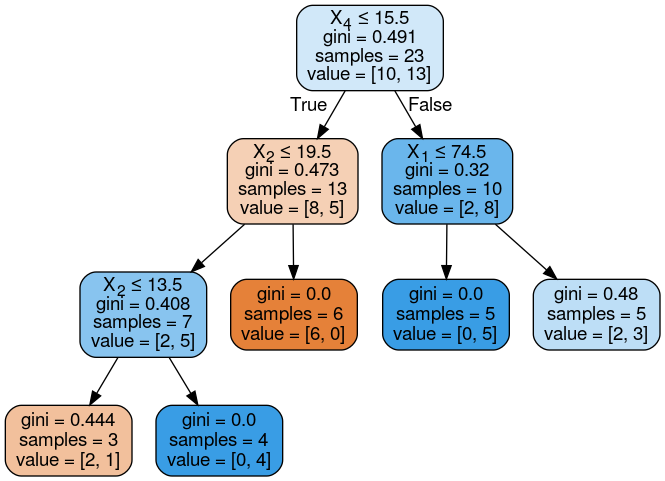

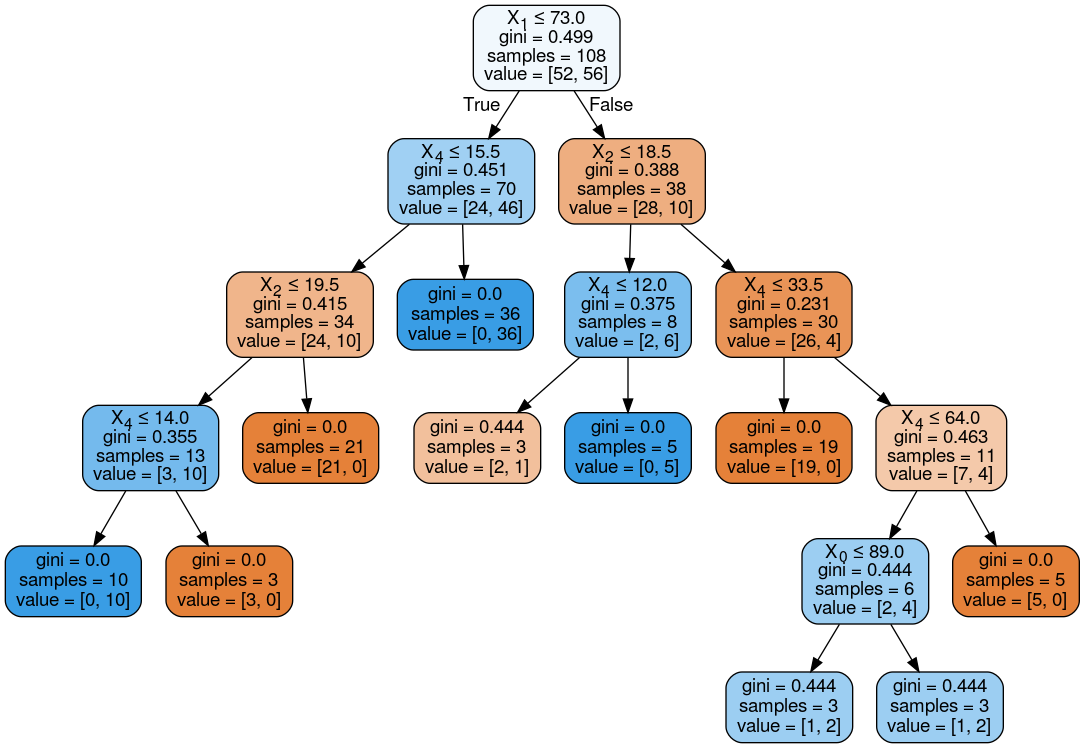

0.6106194690265486 0.6283185840707964


In [45]:


train_data,test_data = read_data(dataset_path)
train_x,train_y = divide_xy(train_data)
test_x , test_y = divide_xy(test_data)

labeled_data,unlabeled_data , rate_p,tuple_list_pn = split_trainset(train_data)

a1 , img1 = evaluate_classifier(base_classifier , labeled_data  , test_data)

total_labeled_data = self_labeling(labeled_data , unlabeled_data , 1, 
                                   rate_p,tuple_list_pn ,
                                   confidence=0.9,selection_rate = 4,confidence_method_name='Probability')

a2 , img2 = evaluate_classifier(base_classifier , total_labeled_data  , test_data)


display(img1)
display(img2)
print(a1 , a2)




In [46]:
# train_data,test_data = read_data(dataset_path)
# train_x,train_y = divide_xy(train_data)
# test_x , test_y = divide_xy(test_data)

# labeled_data,unlabeled_data , rate_p,tuple_list_pn = split_trainset(train_data)

# labeled_data
# # unlabeled_data.iloc[0]
# labeled_data.append(unlabeled_data.iloc[0],ignore_index=True)
